In [12]:
# !wget -nc "https://www.dropbox.com/s/cnsgyitrtw40lgs/model.pth?dl=0"


In [1]:
from eva.server.db_api import connect
import nest_asyncio
nest_asyncio.apply()
cursor = connect(host="127.0.0.1", port=8803).cursor()

In [2]:
# cursor.execute("DROP TABLE IF EXISTS SALIENCY;")
# response = cursor.fetch_all()
# print(response)
cursor.execute("LOAD IMAGE 'data/saliency/test2.jpeg' INTO SALIENCY;")
response = cursor.fetch_all()
print(response)
cursor.execute("LOAD IMAGE 'data/saliency/test1.jpeg' INTO SALIENCY;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 15.466954292000004
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.05059716699999939


In [3]:
cursor.execute("""DROP UDF SaliencyMaps;""")
response = cursor.fetch_all()
print(response)

cursor.execute("""CREATE UDF IF NOT EXISTS 
                  SaliencyMaps
                  INPUT (data NDARRAY UINT8(3, 224, 224)) 
                  OUTPUT (saliency ANYTYPE) 
                  TYPE  Classification 
                  IMPL 'eva/udfs/saliency_map.py';
        """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF SaliencyMaps successfully dropped
@query_time: 0.1530285000000049
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF SaliencyMaps successfully added to the database.
@query_time: 3.2717453749999947


In [4]:
cursor.execute("""SELECT data, SaliencyMaps(data)
                  FROM SALIENCY
                  """)
response = cursor.fetch_all()
print(response.batch)

                                                                                         saliency.data   
0  [[[30 31 13]\n [33 34 16]\n [33 34 20]\n [41 42 28]\n [29 29 17]\n [32 32 20]\n [22 22 12]\n [35...  \
1  [[[0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0...   

                                                                                 saliencymaps.saliency  
0  [tensor([[0.0033, 0.0036, 0.0017,  ..., 0.0032, 0.0009, 0.0013],\n        [0.0034, 0.0034, 0.002...  
1  [tensor([[0.0020, 0.0017, 0.0008,  ..., 0.0002, 0.0000, 0.0000],\n        [0.0036, 0.0035, 0.001...  


In [16]:
df = response.batch.frames
df

,mri.data,mricnn.saliency
0,"[[[13, 31, 30], [16, 34, 33], [20, 34, 33], [2...","[[[tensor(0.0005), tensor(0.0003), tensor(0.00..."
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[tensor(0.0020), tensor(0.0017), tensor(0.00..."


In [17]:
df["mricnn.saliency"][0]

tensor([[[0.0005, 0.0003, 0.0004,  ..., 0.0035, 0.0042, 0.0036],
         [0.0013, 0.0011, 0.0022,  ..., 0.0066, 0.0100, 0.0091],
         [0.0006, 0.0020, 0.0040,  ..., 0.0175, 0.0233, 0.0203],
         ...,
         [0.0005, 0.0004, 0.0010,  ..., 0.0035, 0.0008, 0.0015],
         [0.0002, 0.0002, 0.0005,  ..., 0.0023, 0.0007, 0.0008],
         [0.0001, 0.0005, 0.0001,  ..., 0.0022, 0.0003, 0.0006]]])

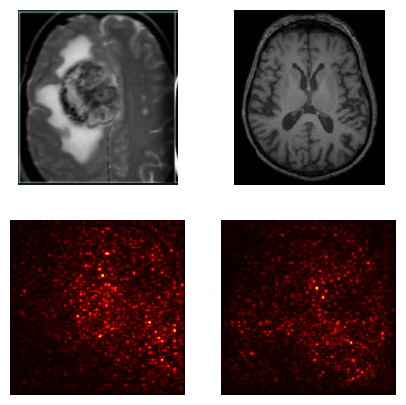

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
df = response.batch.frames
fig, ax = plt.subplots(nrows=2, ncols=len(df), figsize=[15,18])

for i in range(len(df)):
  img = df['mri.data'].iloc[i]
  ax[0,i].imshow(img)
  ax[1,i].imshow(df["mricnn.saliency"][i][0],cmap=plt.cm.hot)
  ax[0,i].axis('off')
  ax[1,i].axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()